In [1]:
import math, copy, sys, logging, json, time, random, os

import numpy as np
from itertools import cycle
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter

import torchvision
from torchvision import datasets, transforms

from scripts.Memory import *

%load_ext autoreload
%autoreload 2

print('torch.version',torch.__version__)
print('torch.cuda.is_available()',torch.cuda.is_available())

torch.version 1.3.0
torch.cuda.is_available() True


[GENERATIVE TEMPORAL MODELS WITH MEMORY](https://arxiv.org/pdf/1702.04649.pdf)

In [2]:
params = RecallTaskMNISTParams()

# Variational Autoencoder

A neural network maps an input tensor to the mean and log variance of the latent variable z. z is then sampled in a differentiable manner from the distribution parameterized by the mean and log variance. 

## Relation between prior and posterior of the Latent variable 

if you look at the forward method of the VAE and the variables passed into it in the combined model

def forward(self, psi_t, x_t, batch_size):

self.state.latentstate.state, X_mean, elbo = self.vae(self.state.readstate.r, X, batch_size)

the context psi_t is the same as the read vector self.state.readstate.r

There are two functions that are being learned by the VAE 

<img src="saved/images/priorposterior.png">

The prior is a diagonal Gaussian that depends on the memory context through the prior map f_z

The posterior is a diagonal Gaussian that depends on the observation x_t and the memory context Ψ_t−1 through a posterior map f_q

f_z and f_q are both neural networks that predict the latent variable z, the ELBO simultaneously pushes f_z to encode a latent variable z that can generate x_t as well as a f_q that encodes a latent variable z that encodes the same information that f_z does

## sampling z

Since the neural network outputs positive or negative valued vectors, we predict the log variance instead of the variance, since the log variance is negative for variances less than 1 and positive for variances greater than 1. Then we convert the log variance to standard deviation  using `(0.5 * z_logvar).exp()` 

$$ e^{0.5 \cdot \log \sigma^2} = \sigma $$

The KL-divergence between two gaussians is outlined in this article https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians basically you need each distribution's mean and variance 

$$
KL(p, q) = \int p(x) \log \frac{p(x)}{q(x)} dx
$$

$$
= - \int p(x) \log q(x) dx + \int p(x) \log p(x) dx
$$

$$
=\frac{1}{2} \log (2 \pi \sigma_2^2) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2} (1 + \log 2 \pi \sigma_1^2)
$$

$$
= \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$$

$$
= \log \sigma_2 - \log \sigma_1 + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$$

$$
= \frac{\log \sigma_2^2 - \log \sigma_1^2}{2} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$$

$$
= \frac{1}{2} ( \log \sigma_2^2 - \log \sigma_1^2 + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{\sigma_2^2} - 1) 
$$


The coded version of the function above is below

`kld_element = `

`logvar_2 - logvar_1 + (logvar_1.exp() + (mean_1-mean_2).pow(2))/(logvar_2.exp()+1e-8) - 1`

`return 0.5 * torch.sum(kld_element, dim = 1)`

For the Reconstruction Loss we use negative log likelihood of Bernoulli 
random variable x, parameteried by p. In the VAE example, p is the output of the decoder [0,1], and x is the input {0,1}.

The probability of x = 1 in bernoulli is theta, sometimes p, but i used theta s to not confuse this with marginal probability p(x)

$$ p(x) = theta^{x}(1-theta)^{(1-x) $$

Likelihood of a series of x random variables where x is {0 or 1}, and x is sampled n times is

$$
L(p) = \prod_{i=1}^n p^{x_i}(1-p)^{(1-x_i)}
$$

The log-likelihood of a series of x random variables where x is {0 or 1}, and x is sampled n times is

$$
\log [L(p)] = \log{p}\sum_{i=1}^n x_i + \log{(1-p)}\sum_{i=1}^n (1-x_i)
$$

The coded version of the function above is below, with a negative sign for negative log-likelihood (nll) 

`-torch.sum(x*torch.log(p+1e-8)+(1-x)*torch.log(1-p+1e-8),dim=1)`

You might be used to seeing this formulas variables reversed,
note that if x = y and p = x,this is the same as Binary Cross Entropy.

ELBO (evidence lower bound  also called variational lower bound) is the objective function for a variational baysian method called inference optimization duality whereby you infer
the value of a random variable given the value of another random variable by finding parameter values that minimize some objective function

http://users.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf explains why ELBO is a lower bound of the log probability of observations log(p(x)).

p(x) = marginal likelihood aka marginal probability of x 

$$ELBO = \log p(x) - KL[ q(z) || p(z|x)] $$

in the forward pass of the variational autoencoder

`kld = self._kld_gauss(z_mean, z_logvar, z_mean_prior, z_logvar_prior)`
`nll = self._nll_bernoulli(_x_t_mean, x_t)`
`elbo_t = - nll - kld`

a double negative is used in the ELBO which is confusing, nll = -loglikelihood, plugging this back into 

`elbo_t = - nll - kld` 

we get 

`elbo_t = loglikelihood - KLdivergence` 

to maximize the marginal probability, we can instead maximize its variational lower bound (ELBO) or minimize the negative mean ELBO

in the training loop

`mean_neg_elbo = -elbo.mean()` 
`mean_neg_elbo.backward()`

the result is that we minimize the KL divergence while also minimizing the reconstruction loss aka maximizine the loglikelihood, log(p(x)), when p(x) is the bernoulli marginal likelihood



In [26]:
class VariationalModelBase(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, psi_dim):
        super(VariationalModelBase, self).__init__()

        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.psi_dim = psi_dim

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        self.to(self.device)

        self.init_nn_layers()

    def init_nn_layers(self):
        raise NotImplementedError

    def forward(self, psi_t, x_t, batch_size):

        # compute Q(Z|X) given context and x_t
        z_enc = self.inf(torch.cat([psi_t, x_t], dim=1))
        z_mean = self.inf_mean(z_enc)
        z_logvar = self.inf_logvar(z_enc)

        # compute prior over z_t given context
        z_enc_prior = self.prior(psi_t)
        z_mean_prior = self.prior_mean(z_enc_prior)
        z_logvar_prior = self.prior_logvar(z_enc_prior)

        # get a sample of z_t
        z_sample = self.sample_gaussian(z_mean, (0.5 * z_logvar).exp())

        # get distribution over x_t given z_t and the context
        _x_t_enc = self.gen(torch.cat([psi_t, z_sample], dim=1))
        _x_t_mean = self.gen_mean(_x_t_enc)

        # compute kld, log-likelihood of x_t and sub-elbo
        kld = self._kld_gauss(z_mean, z_logvar, z_mean_prior, z_logvar_prior)
        nll =  self._nll_bernoulli(_x_t_mean, x_t)
        elbo_t = - nll - kld

        return z_sample, _x_t_mean, elbo_t

    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)


    def sample_gaussian(self, mean, std):
        normalsample = torch.randn(mean.size(), device = self.device)
        return normalsample * std + mean  # scale the vector based on std and add mean


    def sample_x_mean(self, psi):
        # compute prior over z_t given context
        z_enc_prior = self.prior(psi)
        z_mean_prior = self.prior_mean(z_enc_prior)
        z_logvar_prior = self.prior_logvar(z_enc_prior)
        z_sample = self.sample_gaussian(z_mean_prior, (0.5 * z_logvar_prior).exp())
        x_enc = self.gen(torch.cat([psi, z_sample], dim=1))
        x_gen_mean = self.gen_mean(x_enc)
        return z_sample, x_gen_mean


    def _kld_gauss(self, mean_1, logvar_1, mean_2, logvar_2):
        """Using std to compute KLD"""

        kld_element = logvar_2 - logvar_1 + \
                      (logvar_1.exp() + (mean_1-mean_2).pow(2)) / (logvar_2.exp()+1e-8) - 1
        
        return 0.5 * torch.sum(kld_element, dim = 1)


    def _nll_bernoulli(self, p, x):
        """ 
        Reconstruction Loss: negative log likelihood of Bernoulli 
        random variable x, parameteried by p.
        You might be used to seeing this formulas variables reversed,
        note that if x = y and p = x,this is the same as Binary Cross Entropy.
        # return F.binary_cross_entropy(p, x, size_average=False)
        In the VAE example, p is the output of the decoder [0,1],
        and x is the input {0,1}. 
        """
        return -torch.sum(x*torch.log(p+1e-8)+(1-x)*torch.log(1-p+1e-8),dim=1)
        
class ConvNetEncoder(nn.Module):
    def __init__(self, psi_dim, h_dim, z_dim):
        super(ConvNetEncoder, self).__init__()

        self.psi_dim = psi_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        self.bn1 = nn.BatchNorm2d(1)
        self.conv1x1_1 = nn.Conv2d(1, 8, kernel_size=1, padding=2)
        self.conv3x3_1 = nn.Conv2d(1, 8, kernel_size=3, padding=3)
        self.conv5x5_1 = nn.Conv2d(1, 8, kernel_size=5, padding=4)
        self.conv7x7_1 = nn.Conv2d(1, 8, kernel_size=7, padding=5)
        self.conv_dim_halving_1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv1x1_2 = nn.Conv2d(32, 8, kernel_size=1, padding=0)
        self.conv3x3_2 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
        self.conv5x5_2 = nn.Conv2d(32, 8, kernel_size=5, padding=2)
        self.conv7x7_2 = nn.Conv2d(32, 8, kernel_size=7, padding=3)
        self.conv_dim_halving_2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(8 * 8 * 64, 64)
        self.fc2_mean = nn.Linear(32 + psi_dim, h_dim)
        self.fc2_logvar = nn.Linear(32 + psi_dim, h_dim)
        self.fc3_mean = nn.Linear(h_dim, z_dim)
        self.fc3_logvar = nn.Linear(h_dim, z_dim)

    def forward(self, psi, x):
        x = x.view(-1, 1, 28, 28)

        x = self.bn1(x)
        x = F.relu(x)
        x = torch.cat([
            self.conv1x1_1(x),
            self.conv3x3_1(x),
            self.conv5x5_1(x),
            self.conv7x7_1(x)
        ], dim=1)
        x = self.conv_dim_halving_1(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = torch.cat([
            self.conv1x1_2(x),
            self.conv3x3_2(x),
            self.conv5x5_2(x),
            self.conv7x7_2(x)
        ], dim=1)
        x = self.conv_dim_halving_2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = self.fc1(x)
        x_mean = F.relu(self.fc2_mean(torch.cat([psi, x[:,:32]], dim = 1)))
        x_logvar = F.relu(self.fc2_logvar(torch.cat([psi, x[:,32:]], dim = 1)))

        x_mean = self.fc3_mean(x_mean)
        x_logvar = self.fc3_logvar(x_logvar)

        return x_mean, x_logvar

class ConvNetDecoder(nn.Module):
    def __init__(self, psi_dim, h_dim, z_dim):
        super(ConvNetDecoder, self).__init__()

        self.psi_dim = psi_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        self.fc1 = nn.Linear(psi_dim + z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 64 * 8 * 8)
        self.deconv_dim_doubling_1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(32)

        self.deconv1x1_1 = nn.ConvTranspose2d(8, 32, kernel_size=1, padding=0)
        self.deconv3x3_1 = nn.ConvTranspose2d(8, 32, kernel_size=3, padding=1)
        self.deconv5x5_1 = nn.ConvTranspose2d(8, 32, kernel_size=5, padding=2)
        self.deconv7x7_1 = nn.ConvTranspose2d(8, 32, kernel_size=7, padding=3)

        self.bn2 = nn.BatchNorm2d(32)

        self.deconv_dim_doubling_2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1)

        self.bn3 = nn.BatchNorm2d(32)

        self.deconv1x1_2 = nn.ConvTranspose2d(8, 1, kernel_size=1, padding=0)
        self.deconv3x3_2 = nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1)
        self.deconv5x5_2 = nn.ConvTranspose2d(8, 1, kernel_size=5, padding=2)
        self.deconv7x7_2 = nn.ConvTranspose2d(8, 1, kernel_size=7, padding=3)


    def forward(self, psi_cat_z):

        x = F.relu(self.fc1(psi_cat_z))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 8, 8)
        x = self.deconv_dim_doubling_1(x, output_size=(16,16))
        x = self.bn1(x)
        x = F.relu(x)

        x = self.deconv1x1_1(x[:,0:8,:,:]) + self.deconv3x3_1(x[:,8:16,:,:]) + self.deconv5x5_1(x[:,16:24,:,:]) + self.deconv7x7_1(x[:,24:32,:,:])
        x = self.bn2(x)
        x = F.relu(x)

        x = self.deconv_dim_doubling_2(x, output_size=(32,32))
        x = self.deconv1x1_2(x[:,0:8,:,:]) + self.deconv3x3_2(x[:,8:16,:,:]) + self.deconv5x5_2(x[:,16:24,:,:]) + self.deconv7x7_2(x[:,24:32,:,:])
        x = torch.sigmoid(x)

        x = x[:,0,2:30,2:30] #remove padding
        x = x.contiguous().view(-1,28*28) #unwrap the image

        return x
    
class VariationalConvDeconv(VariationalModelBase):
    def init_nn_layers(self):

        x_dim = self.x_dim
        h_dim = self.h_dim
        z_dim = self.z_dim
        psi_dim = self.psi_dim

        # generator
        self.gen = ConvNetDecoder(psi_dim, h_dim, z_dim)

        # inference
        self.inf = ConvNetEncoder(psi_dim, h_dim, z_dim)

        # prior
        self.prior = nn.Sequential(
            nn.Linear(psi_dim, h_dim),
            nn.ReLU())
        
        self.prior_mean = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )
        self.prior_logvar = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )

    def forward(self, psi_t, x_t, batch_size):
        """
        input:
            psi_t - context, read vector from memory (batch_size, memory_m)
            x_t - input vector (batch_size, input dimensions)
        output:
            z_sample - latentstate (batch_size, memory_m)
            _x_t_mean - output vector (batch_size, input dimensions)
            elbo_t - evidence lower bound (batch_size,)
        """
        # Posterior Q(Z_t|X_t,Z_<t) = N(zt|z_mean(psi<t,xt), z_logvar(psi<t,xt)) 
        # aka z given context and x_t
        z_mean, z_logvar = self.inf(psi_t, x_t)

        # Prior P(Z_t|X<t,Z<t) = N(zt|z_mean(psi<t), z_logvar(psi<t)) 
        # aka prior over z_t given context
        z_enc_prior = self.prior(psi_t)
        z_mean_prior = self.prior_mean(z_enc_prior)
        z_logvar_prior = self.prior_logvar(z_enc_prior)

        # get a sample of z_t
        z_sample = self.sample_gaussian(z_mean, (0.5 * z_logvar).exp())

        # get distribution over x_t given z_t and the context
        x_mean = self.gen(torch.cat([psi_t, z_sample], dim=1))

        # compute kld between the posterior and prior 
        kld = self._kld_gauss(z_mean, z_logvar, z_mean_prior, z_logvar_prior)
        # log-likelihood of x_t and x_mean (sub-elbo) 
        nll = self._nll_bernoulli(x_mean, x_t)  
        elbo_t = - nll - kld # Reconsruction loss and KL divergence 

        return z_sample, x_mean, elbo_t

    def sample_x_mean(self, psi):
        """ used in the generate method of the combined model """
        # compute prior over z_t given context
        z_enc_prior = self.prior(psi)
        z_mean_prior = self.prior_mean(z_enc_prior)
        z_logvar_prior = self.prior_logvar(z_enc_prior)
        z_sample = self.sample_gaussian(z_mean_prior,(0.5*z_logvar_prior).exp())
        x_mean = self.gen(torch.cat([psi, z_sample], dim=1))
        return z_sample, x_mean

In [27]:
class ReadState(nn.Module):
    def __init__(self, memory):
        super(ReadState, self).__init__()
        self.memory = memory

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

    def reset(self, batch_size):
        self.w = torch.zeros(batch_size, self.memory.N, device = self.device)
        self.w[:,0] = 1.0 # set reader attention at first spot in the memory
        self.r = self.memory.read(self.w)

class ControllerState(nn.Module):
    def __init__(self, controller):
        super(ControllerState, self).__init__()
        self.controller = controller

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

        # starting hidden state is a learned parameter
        self.lstm_h = Parameter(torch.randn(self.controller.num_layers, 
                                                 1, self.controller.hidden_size) * 0.05)
        
        self.lstm_c = Parameter(torch.randn(self.controller.num_layers, 
                                                 1, self.controller.hidden_size) * 0.05)

        self.to(self.device)

    def reset(self, batch_size):
        h = self.lstm_h.clone().repeat(1, batch_size, 1)
        c = self.lstm_c.clone().repeat(1, batch_size, 1)
        self.state = h, c

class LatentState(nn.Module):
    def __init__(self, latent_size):
        super(LatentState, self).__init__()

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

        self.latent_size = latent_size

    def reset(self, batch_size):
        self.state = torch.zeros(batch_size, self.latent_size, device = self.device)

class State(nn.Module):
    def __init__(self, memory, controller):
        super(State, self).__init__()
        self.memory = memory
        self.controller = controller

    def reset(self, batch_size):
        # setup readstate
        self.readstate = ReadState(self.memory)
        self.readstate.reset(batch_size)

        # setup controller state
        self.controlstate = ControllerState(self.controller)
        self.controlstate.reset(batch_size)

        # setup latent state
        self.latentstate = LatentState(self.memory.M)
        self.latentstate.reset(batch_size)

In [28]:
class LSTMController(nn.Module):
    """
    A Neural Turing Machine controller based on LSTM
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMController, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers)

        self.reset_parameters()

        self.to(self.device)

    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)

    def forward(self, x, prev_state):
        """
        input:
             x - latentstate (batch_size, memory_m),
                 the current hidden state output from 
                 last layer of LSTM (seq_len=1, batch, directions*hidden_size)
                 
             prev_state - controlstate is a tuple,
                          previous hidden and cell state (h, c)
                          (num_layers*num_directions, batch, memory_m)
        output:
            outp -  the hidden state from the last layer of the LSTM, 
                    for each t, in seq_len, here seq_len = 1, so it is 
                    squeezed out with .squeeze(0)
                    (seq_len, batch_size, num_directions*memory_m)
            state - tuple containing the hidden and cell state at 
                    the last time step t in seq_len. both
                    (num_layers*num_directions, batch, memory_m)
        """
        x = x.unsqueeze(0) 
        outp, state = self.lstm(x, prev_state)
        return outp.squeeze(0), state

# Neural Turing Machine

The main NTM class. We will explore the mechanics of addressing, reading and writing in the cells below the NTM class

In [29]:
class NTM(nn.Module):
    """ Neural Turing Machine Memory"""
    def __init__(self, N, M, controller_size):
        
        """Initialize the Memory matrix.
        The memory's dimensions are (batch_size x N x M).
        Each batch has it's own memory matrix.
        N: Number of rows in the memory.
        M: Number of columns/features in the memory.
        """
        super(NTM, self).__init__()

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

        self.N = N
        self.M = M
        self.controller_size = controller_size

        self.memory0 = torch.ones(self.N, self.M, 
                                  device = self.device).abs_()*1e-6

        # create Fully Connected layer for addressing using controller output
        self.address_params_sizes = [self.M, 1, 1, 3, 1]
        self.addresses =  nn.Linear(self.controller_size, 
                                    sum(self.address_params_sizes))  # sums to 26
        self.to(self.device)

    def reset(self, batch_size):
        """Reset the memory"""
        self.batch_size = batch_size
        self.write_loc = 0

        self.memory = self.memory0.clone().repeat(batch_size, 1, 1)

    def visualize(self, savefile):
        torchvision.utils.save_image(self.memory, savefile)

    def size(self):
        return self.N, self.M

    def read(self, w):
        """Read from memory (according to section 3.1)"""
        return torch.matmul(w.unsqueeze(1), self.memory).squeeze(1)

    def write(self, a):
        if a is None:
            return
        
        w = torch.zeros(self.batch_size, self.N)
        w[:, self.write_loc] = 1.0
        e = torch.ones(self.batch_size, self.M)
        
        if torch.cuda.is_available():
            self.memory = self.memory.cuda()
            w = w.cuda()
            e = e.cuda()
            a = a.cuda()

        erase = torch.matmul(w.unsqueeze(-1), e.unsqueeze(1))
        add = torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))

        # write to memory
        self.memory = self.memory * (1 - erase) + add
        self.write_loc = (self.write_loc + 1) % self.N

    def address(self, controller_output, w_prev):
        """NTM Addressing (according to section 3.3)
           both w_prev and ware Softmax weightings over rows 
           of the memory matrix with shapes (batch_size, memory_n)
        input:
            controller_output- (batch_size, controller_size)
            w_prev - The weighting produced in the previous time step
        output:
            w - new Softmax weighting over rows of the memory matrix
        """
        address_params = self.addresses(controller_output)
        
        k, beta, g, s, gamma = self.split_cols(address_params, 
                                               self.address_params_sizes)
        """
        k - The key vector (batch_size, memory_m) (a vector)
        beta - The key strength (focus) (batch_size, 1) (0,infinity)
        g - Scalar interpolation gate with w_prev (batch_size, 1) (0,1)
        s - Shift weighting (batch_size, memory_n) (sums to 1)
        gamma - Sharpen weighting scalar (batch_size, 1) (1,infinity)
        """
        beta = F.softplus(beta)
        g = torch.sigmoid(g)
        s = F.softmax(s, dim=1)
        gamma = 1 + F.softplus(gamma)
        # Content Addressing
        wc = self._similarity(k, beta)
        # Location Adressing
        wg = self._interpolate(w_prev, wc, g)
        w_hat = self._shift(wg, s)
        w = self._sharpen(w_hat, gamma)

        return w

    def split_cols(self, mat, lengths):
        """Split a 2D matrix to variable length columns."""
        assert mat.size()[1] == sum(lengths), "Lengths must be summed to num columns"
        l = np.cumsum([0] + lengths) # [ 0, 20, 21, 22, 25, 26]
        results = []
        for s, e in zip(l[:-1], l[1:]):  # 0 20, 20 21, ... 
            results += [mat[:, s:e]]
        return results
    
    def _similarity(self, k, beta):
        k = k.view(self.batch_size, 1, -1)
        w = F.softmax(beta * F.cosine_similarity(self.memory + 1e-16, 
                                                 k + 1e-16, dim=-1), dim=1)
        return w

    def _interpolate(self, w_prev, wc, g):
        return g * wc + (1 - g) * w_prev

    def convolve(self, w, s):
        """Circular convolution implementation."""
        assert s.size(0) == 3
        t = torch.cat([w[-1:], w, w[:1]])
        c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1) 
        # .view(-1) gets rid of the first two 1 dims inc
        return c
    
    def _shift(self, wg, s):
        result = torch.zeros(wg.size(), device = self.device)
        for b in range(self.batch_size):
            result[b] = self.convolve(wg[b], s[b])
        return result

    def _sharpen(self, w_hat, gamma):
        w = w_hat ** gamma
        w = torch.div(w, torch.sum(w, dim=1).view(-1, 1) + 1e-16)
        return w
    

In [30]:
# lets suppose that the rows of memory = 4, the columns of memory = 5, rnn hidden = 6 and batch_size = 1
memory_n = 4
memory_m = 5
controller_size = 6
batch_size = 1
ntm = NTM(memory_n, memory_m, controller_size)
ntm.reset(batch_size)
print("memory matrix\n", ntm.memory.shape)


memory matrix
 torch.Size([1, 4, 5])


## The Controller 

At each timestep the controller takes in information about the environment in the form of the latent state, along with information about the it's past actions and environments in the form on the controller state and generates a vector `cout` used to address reading from the memory, ie query.  cout -> (k, beta, g, s, gamma) -> w  

The LSTM has 3 inputs and 3 outputs: 
input, hidden_state, cell_state = latent state, controller hidden, controller cell
output, hidden_state, cell_state = controller output vector (cout), controller hidden, controller cell

`self.state.readstate.w = self.memory.address(cout, self.state.readstate.w)`
        
`self.state.readstate.r = self.memory.read(self.state.readstate.w)`

Notice the use of the softplus function. The softplus function is quite similar to the Rectified Liner Unit with outputs in the range (0, ∞), with the main difference being softplus differentiability at the x = 0

<img src="saved/images/activationfunction.png" width=400 height=400>


In [31]:
num_layers = 1
lstm = LSTMController(input_size = memory_m, hidden_size = controller_size, num_layers = num_layers)
state = State(ntm, lstm)
state.reset(batch_size)
print("latent state", state.latentstate.state.shape) # this is the top lstm layer hidden state (batch_size, memory_m)
cout, state.controlstate.state = lstm(state.latentstate.state, state.controlstate.state)
h, c = state.controlstate.state
print("cout.shape, h.shape, c.shape (num_layers*num_directions=1, batch=1, hidden_size=1)")
print(cout.shape, h.shape, c.shape) 
state.readstate.w = ntm.address(cout, state.readstate.w)
print("w.shape", state.readstate.w.shape)
address_params = ntm.addresses(cout)
k, beta, g, s, gamma = ntm.split_cols(address_params, ntm.address_params_sizes)
print(k.data)
print(beta.data, g.data)
beta = F.softplus(beta)
g = torch.sigmoid(g)
print(beta.data, g.data)



latent state torch.Size([1, 5])
cout.shape, h.shape, c.shape (num_layers*num_directions=1, batch=1, hidden_size=1)
torch.Size([1, 6]) torch.Size([1, 1, 6]) torch.Size([1, 1, 6])
w.shape torch.Size([1, 4])
tensor([[ 0.0662, -0.1405,  0.1248,  0.2219, -0.1425]], device='cuda:0')
tensor([[0.0218]], device='cuda:0') tensor([[0.0404]], device='cuda:0')
tensor([[0.7041]], device='cuda:0') tensor([[0.5101]], device='cuda:0')


The [Neural Turing Machine paper](https://arxiv.org/pdf/1410.5401.pdf) explains the components of neural memory. [This blog](https://rylanschaeffer.github.io/content/research/neural_turing_machine/main.html) does a great job expalaining the paper to technical non-researchers. 

## Addressing
Adressing is creating weight vectors across the rows of the memory to determine where to read and write. Each stage generates an intermediate weight vector that gets passed to the next stage. First is content addressing:

### Content Adressing 
generates a weight vector based on how similar each row in memory is to a length-C vector key k_t emitted by the controller

<img src="https://rylanschaeffer.github.io/content/research/neural_turing_machine/ntm_addr_1.png">

For each head, the controller produces a key vector kt that is compared to each row of Mt using a similarity measure. In this paper, the authors use cosine similarity

$$ K(k_t, M_t(i)) = \frac{k_t \cdot M_t(i)}{\|k_t\| \cdot \|M_t(i)\|}$$ 

The PyTorch version of this formula is 

`F.cosine_similarity(self.memory + 1e-16, k + 1e-16, dim=-1)`

The variable `wc` in ` wc = self._similarity(k, beta)` is the weighted softmax of these similarities and can be used as and an attention weighting over the rows of the matrix based on similarity to a generated vector k. Larger betas cause the distribution over the rows of the memory to be more concentrated on the highest cosine similarity row, thus beta is called the key strength or focus.

$$w_t^c(i) = \frac{exp\Big(\beta_t K (k_t, M_t(i))\Big)}{\sum_j exp\Big(\beta_t K(k_t, M_t(j))\Big)}$$

`wc = F.softmax(beta * F.cosine_similarity(self.memory + 1e-16, k + 1e-16, dim=-1), dim=1)`

In [32]:
print(ntm.memory.shape, k.shape)
cos_sim = F.cosine_similarity(ntm.memory + 1e-16, k + 1e-16, dim=-1)
print(cos_sim.shape)
wc = F.softmax(beta * cos_sim, dim=1)
print(wc.shape, beta.shape)

torch.Size([1, 4, 5]) torch.Size([1, 5])
torch.Size([1, 4])
torch.Size([1, 4]) torch.Size([1, 1])


## location-based addressing

In some cases, we may want to read from specific memory locations instead of looking for specific memory values. The example the authors give is the function f(x,y)=x∗y. In this case, we don't care what the values of x and y are, just that x and y are consistently read from the same memory locations. This is called location-based addressing, and to implement it, we'll need three more stages. In the second stage, a scalar parameter g ∈ (0,1), called the interpolation gate, blends the content weight vector wc with the previous time step's weight vector w_t−1 to produce the gated weighting wg. This allows the system learn when to use (or ignore) content-based addressing.

<img src="https://rylanschaeffer.github.io/content/research/neural_turing_machine/ntm_addr_2.png">

$$w_t^g \leftarrow g_t w_t^c + (1- g_t) w_{t-1}$$

                                              wg = g * wc + (1 - g) * w_prev
                                              

In [33]:
# for demonstration purposes we use a random w_prev
w_prev = F.softmax(torch.rand((batch_size, memory_n)), dim = -1)
if torch.cuda.is_available():
    w_prev = w_prev.cuda()
print("w_prev", w_prev.data)
print("g", g.data)
wg = g * wc + (1 - g) * w_prev
print("wg", wg.data, wg.shape)


w_prev tensor([[0.2686, 0.2873, 0.2011, 0.2431]], device='cuda:0')
g tensor([[0.5101]], device='cuda:0')
wg tensor([[0.2591, 0.2683, 0.2260, 0.2466]], device='cuda:0') torch.Size([1, 4])


## Shift

s - Shift weighting (batch_size, memory_n) (sums to 1)

We'd like the controller to be able to shift focus to other rows. Let's suppose that as one of the system's parameters, the range of allowable shifts is specified. For example, a head's attention could shift forward a row (+1), stay still (0), or shift backward a row(-1). 

<img src="https://rylanschaeffer.github.io/content/research/neural_turing_machine/ntm_addr_3.png">

We'll perform the shifts modulo R so that a shift forward at the bottom row of memory moves the head's attention to the top row, and similarly for a shift backward at the top row. After interpolation, each head emits a normalized shift weighting st, and the following convolutional shift is performed to produce the shifted weight w_hat

$$\tilde{w}_t(i) \leftarrow \sum\limits_{j=0}^{R-1} w_t^g(j) s_t(i-j)$$

                           F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)

I never liked this notation for convolution. it leaves alot unsaid. think of s as being sliding window dot product, if you have already done the intro to pytorch lesson with 2D image convolutions, you might think of s as a filter of size 3 being applied to the image wg. To create the wrap-around padding effect, the last element is appended to the beginning and the first element is appended to the end. since the filter size is 3, this is just the right padding to result in an output tensor of the same size as the input. 

The F.conv1D function takes an input of shape (batch_size, input channels, sequence length), filter of shape (output channels, input channels, filter length) and outputs a tensor of shape (batch_size, output channels, output sequence length) 

If you are wondering why we have a for loop that goes through each sample in the batch, it is because we are not sharing weights across samples, each sample's filter is indenpendant and is part of its own independant history of states and actions, this is not a 1:1 mapping task where we are doing the same task for every sample in the batch 


In [34]:
# a quick reminder that s is a probability density and so is wg
print("s",s.data)
s = F.softmax(s, dim=1)
# to demonstrate, here is the convolution operation performed on a single sample 
shift = s[0]
w_gate = wg[0]
print("shift", shift.data, shift.shape)
print("wg", w_gate.data, w_gate.shape)
t = torch.cat([w_gate[-1:], w_gate, w_gate[:1]])
print("t",t.view(1, 1, -1).data, t.view(1, 1, -1).shape)
c = F.conv1d(t.view(1, 1, -1), shift.view(1, 1, -1)).view(-1) # .view(-1) gets rid of the first two 1 dims 
print("c", c.data, c.shape)
# the first and last window of a sliding window dot product between s and wg, ie convolution
print(torch.einsum('ijk,ijk->ij', [t.view(1, 1, -1)[:,:,:3], s.view(1, 1, -1)]))
print(torch.einsum('ijk,ijk->ij', [t.view(1, 1, -1)[:,:,-3:], s.view(1, 1, -1)]))

s tensor([[ 0.3183, -0.3265, -0.2234]], device='cuda:0')
shift tensor([0.4747, 0.2491, 0.2762], device='cuda:0') torch.Size([3])
wg tensor([0.2591, 0.2683, 0.2260, 0.2466], device='cuda:0') torch.Size([4])
t tensor([[[0.2466, 0.2591, 0.2683, 0.2260, 0.2466, 0.2591]]], device='cuda:0') torch.Size([1, 1, 6])
c tensor([0.2557, 0.2522, 0.2518, 0.2403], device='cuda:0') torch.Size([4])
tensor([[0.2557]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0.2403]], device='cuda:0', grad_fn=<ViewBackward>)


In [35]:
# now lets apply the convolutional shift to the entire batch
w_hat = ntm._shift(wg, s) 
print("w_hat", w_hat.data, w_hat.shape)

w_hat tensor([[0.2557, 0.2522, 0.2518, 0.2403]], device='cuda:0') torch.Size([1, 4])


The fourth and final stage, sharpening, is used to prevent the shifted weight w_hat from blurring. To do this, a scalar gamma >= 1 is required

$$w_t(i) \leftarrow \frac{\tilde{w}_t(i)^{\gamma_t}}{\sum\limits_j \tilde{w}_t(j)^{\gamma_t}}$$



In [36]:
gamma = 1 + F.softplus(gamma) # gamma should be in range 1 to infinity 
w = w_hat ** gamma
w = torch.div(w, torch.sum(w, dim=1).view(-1, 1) + 1e-16)
print("w", w.data, w.shape)


w tensor([[0.2603, 0.2540, 0.2531, 0.2326]], device='cuda:0') torch.Size([1, 4])


## Writing 

$$\mathcal{M}_t^{erased}(i) \leftarrow \mathcal{M}_{t-1}(i)[\mathbf{1} - w_t(i) e_t ]$$

$$\mathcal{M}_t(i) \leftarrow \mathcal{M}_t^{erased}(i) + w_t(i) a_t$$

$$\mathcal{M}_t(i) \leftarrow \mathcal{M}_{t-1}(i)[\mathbf{1} - w_t(i) e_t ] + w_t(i) a_t $$

The initial write function sequentially overwrites rows in the memory whereas the another possibility 
might be to intelligently choose which row to overwrite by learning a write weighting ww and erase vector e.

In [37]:
print(ntm.memory.data)
a = torch.randn(batch_size, memory_m)
print(a.data)
w = torch.zeros(batch_size, memory_n)
w[:, ntm.write_loc] = 1.0
e = torch.ones(batch_size, memory_m)
if torch.cuda.is_available():
    a = a.cuda()
    w = w.cuda()
    e = e.cuda()
erase = torch.matmul(w.unsqueeze(-1), e.unsqueeze(1))
add = torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))
print(erase.data)
print(add.data)
ntm.memory = ntm.memory * (1 - erase) + add
print(ntm.memory.data)
ntm.write_loc = (ntm.write_loc + 1) % ntm.N
print('ntm.write_loc', ntm.write_loc)

tensor([[[1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
         [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06]]],
       device='cuda:0')
tensor([[-1.4638,  0.2284, -1.4672, -0.9524,  0.8018]])
tensor([[[1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], device='cuda:0')
tensor([[[-1.4638,  0.2284, -1.4672, -0.9524,  0.8018],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000]]], device='cuda:0')
tensor([[[-1.4638e+00,  2.2841e-01, -1.4672e+00, -9.5241e-01,  8.0181e-01],
         [ 1.0000e-06,  1.0000e-06,  1.0000e-06,  1.0000e-06,  1.0000e-06],
         [ 1.0000e-06,  1.0000e-06,  1.0000e-06,  1.0000e-06,  1.0000e-06],
         [ 1.0000e-0

# ModelCell 


In [38]:
class ModelCell(nn.Module):
    def __init__(self, params):
        super(ModelCell, self).__init__()

        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")

        # set params
        self.params = params

        # create memory
        self.memory = NTM(params.memory_n, params.memory_m, 
                          params.controller_size)

        # create controller
        self.controller = LSTMController(self.memory.M,
                                         params.controller_size,
                                         params.controller_layers)

        # create state
        self.state = State(self.memory, self.controller)

        # create variational model
        self.vae = VariationalConvDeconv(params.sequence_width,
                                         params.variational_hidden_size,
                                         params.memory_m,
                                         params.memory_m)

        self.to(self.device)

    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)

    def forward(self, X, batch_size):
        """
        the controller is an LSTM: 
        self.state.latentstate.state is x_t
        self.state.controlstate.state is h_t-1 and c_t-1
        
        x_t is a function of h_t-1 thru the address params that read 
        readstate.r from memory and x_t-1 thru latentstate.state
        generated from the VAE's use of X, latentstate.state
        is both written to memory and used as the next x_t 
        """
        cout, self.state.controlstate.state = self.controller(self.state.latentstate.state,
                                                              self.state.controlstate.state)
        
        self.state.readstate.w = self.memory.address(cout, self.state.readstate.w)
        
        self.state.readstate.r = self.memory.read(self.state.readstate.w)
        
        self.state.latentstate.state, X_mean, elbo = self.vae(self.state.readstate.r, X, batch_size)
        
        self.memory.write(self.state.latentstate.state)

        return elbo, X_mean # ELBO (evidence lower bound aka variational lower bound)

    def generate(self):
        
        cout, self.state.controlstate.state = self.controller(self.state.latentstate.state,
                                                              self.state.controlstate.state)
        
        self.state.readstate.w = self.memory.address(cout, self.state.readstate.w)
        
        self.state.readstate.r = self.memory.read(self.state.readstate.w)
        
        self.state.latentstate.state, X_mean = self.vae.sample_x_mean(self.state.readstate.r)
        
        self.memory.write(self.state.latentstate.state)

        return X_mean

In [39]:
# init model cell
modelcell = ModelCell(params)
modelcell.memory.reset(params.batch_size)
modelcell.state.reset(params.batch_size)
modelcell.controller.reset_parameters()
print(modelcell.state.latentstate.state.shape)
optimizer = torch.optim.Adam(modelcell.parameters(), lr=params.adam_lr)


torch.Size([10, 20])


Pass samples throgh the model to probe the information flow and shapes of tensors

In [40]:
X, Y = params.generate_random_batch(device = params.device)

elbo, X_mean = modelcell(X[0], params.batch_size)

In [41]:
def progress_bar(batch_num, report_interval, last_loss, mean_loss):
    """Prints the progress until the next report."""
    progress = (((batch_num - 1.0) % report_interval) + 1.0) / report_interval
    fill = int(progress * 40)
    clear_output(wait = True)
    print("\r\tBATCH [{}{}]: {} (ELBO: {:.4f} Mean ELBO: {:.4f})".format(
        "=" * fill,
        " " * (40 - fill),
        batch_num,
        last_loss,
        mean_loss))

	BATCH [========================================]: 500 (ELBO: 335.1781 Mean ELBO: 379.9128)


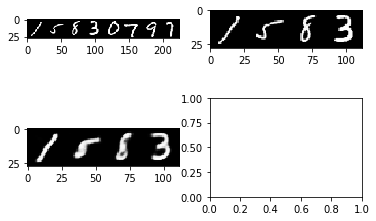

In [43]:
"""START TRAINING MODEL"""

loss_history = []
params.num_batches = 500
for batch_num in range(params.num_batches):
    # reset the states
    modelcell.memory.reset(params.batch_size)
    modelcell.state.reset(params.batch_size)

    # init optimizer
    optimizer.zero_grad()

    # generate data for the copy task
    X, Y = params.generate_random_batch(device = params.device)

    # input phase
    for i in range(X.size(0)):
        _elbo, _ = modelcell(X[i], params.batch_size) #the forward pass predicts elbo, X_mean

    # output phase
    elbo = 0
    for i in range(Y.size(0)):
        _elbo, _ = modelcell(Y[i], params.batch_size) #the forward pass predicts elbo, X_mean
        elbo += _elbo

    # mean ELBO for the entire batch
    mean_neg_elbo = -elbo.mean()
    mean_neg_elbo.backward()

    # log elbo history
    loss_history.append(mean_neg_elbo.data)

    clip_grads(modelcell, params.clip_grad_thresh)
    optimizer.step()

    if (batch_num + 1) % params.save_every == 0:
        
        mean_loss = sum(loss_history[-params.save_every:]) / params.save_every
        progress_bar(batch_num + 1, 
                    params.num_batches, 
                    last_loss=mean_neg_elbo,
                    mean_loss=mean_loss
                    )
        
################### TEST #######################
X, Y = params.generate_illustrative_random_batch(device=params.device)

modelcell.memory.reset(batch_size=1)
modelcell.state.reset(batch_size=1)

attention_history = torch.zeros(1 + X.size(0) + Y.size(0), 
                                modelcell.memory.N, device=params.device)
attention_history[0] = modelcell.state.readstate.w.squeeze()

# input phase
for i in range(X.size(0)):
    _elbo, _ = modelcell(X[i], params.batch_size)
    attention_history[1 + i] = modelcell.state.readstate.w.squeeze()

# output phase
Y_out = torch.zeros(Y.size(), device=params.device)
for i in range(Y.size(0)):
    Y_out[i] = modelcell.generate()
    attention_history[1 + X.size(0) + i] = modelcell.state.readstate.w.squeeze()

Y_out_binary = Y_out.cpu().clone().data
Y_out_binary.apply_(lambda x: 0 if x < 0.5 else 1)

_X = torch.cat([X[i].view(28,28) for i in range(X.size(0))], 
               dim = 1).data.cpu().numpy()

_Y = torch.cat([Y[i].view(28,28) for i in range(Y.size(0))], 
                dim = 1).data.cpu().numpy()

_Y_out = torch.cat([Y_out[i].view(28,28) for i in range(Y_out.size(0))], 
                   dim = 1).data.cpu().numpy()

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(_X, cmap='Greys_r')
axarr[0,1].imshow(_Y, cmap='Greys_r')
axarr[1,0].imshow(_Y_out, cmap='Greys_r')